In [130]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
from time import time
import os
import glob
from pyqg_generative.models.ols_model import OLSModel
from pyqg_generative.models.mean_var_model import MeanVarModel
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.tools.stochastic_pyqg import stochastic_QGModel
from pyqg_generative.tools.spectral_tools import spectrum
from pyqg_generative.tools.comparison_tools import *
import pyqg_parameterization_benchmarks as ppb
from pyqg_generative.tools.operators import Operator1, Operator2, PV_subgrid_forcing, ave_lev
from pyqg_generative.tools.parameters import EDDY_PARAMS
from pyqg_generative.tools.computational_tools import *
import json
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Subgrid forcing at various resolutions

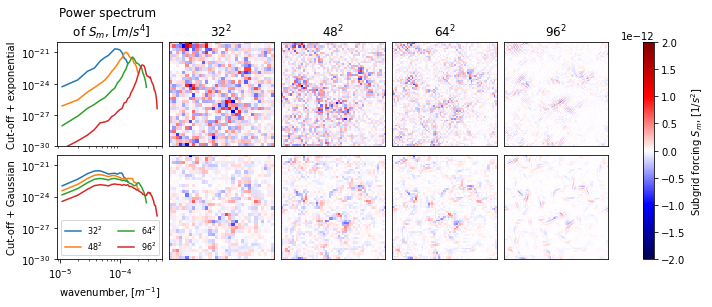

In [328]:
plt.rcParams.update({'font.size': 10})
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc').q.isel(time=-1)
lev=1
if lev==1:
    ylim = [1e-30, 1e-20]
    vmax=2e-12
else:
    ylim = [1e-27, 1e-17]
    vmax=5e-11
fig, axs = plt.subplots(2,5,figsize=(12.5,4))
plt.subplots_adjust(hspace=0.08, wspace=0)
for j, (resolution, res_name) in enumerate(zip([32, 48, 64, 96], ['$32^2$', '$48^2$', '$64^2$', '$96^2$'])):
    for i, (operator, op_name) in enumerate(zip([Operator1, Operator2], ['cut-off + exponential', 'cut-off + Gaussian'])):
        #qc = operator(q, nc)
        forcing = xr.DataArray(PV_subgrid_forcing(q.values, resolution, operator, EDDY_PARAMS)[0], dims=('lev', 'y', 'x'))
        ax = axs[i][j+1]
        im = ax.imshow(forcing.isel(lev=lev).values, vmin=-vmax, vmax=vmax, cmap='seismic', interpolation='none')
        ax.set_box_aspect(1)
        if i==0:
            ax.set_title(res_name)
        ax.set_xticks([])
        ax.set_yticks([])
        
        sp = spectrum(time=slice(None,None))(forcing.expand_dims('time'))
        axs[i][0].loglog(sp.k, sp.isel(lev=lev).values, label=res_name)
        axs[i][0].set_box_aspect(1)
        
        axs[i][0].set_ylim(ylim)
        if i==1:
            axs[i][0].legend(ncol=2, fontsize=8)
plt.colorbar(im, ax=axs, label='Subgrid forcing $S_m$, [$1/s^2$]')
axs[1][0].set_xlabel('wavenumber, [$m^{-1}$]')
axs[0][0].set_title('Power spectrum \n of $S_m$, [$m/s^4$]')
axs[0][0].set_ylabel('Cut-off + exponential')
axs[1][0].set_ylabel('Cut-off + Gaussian')
axs[0][0].set_xticks([])
plt.savefig('paper_figures/forcing_lower.pdf', bbox_inches='tight', pad_inches=0)

# Convergence of cGAN

In [166]:
stats_none = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-None-long/model/stats.nc')
stats_correction = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/model/stats.nc')
#stats_residual = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression-residual/model/stats.nc')

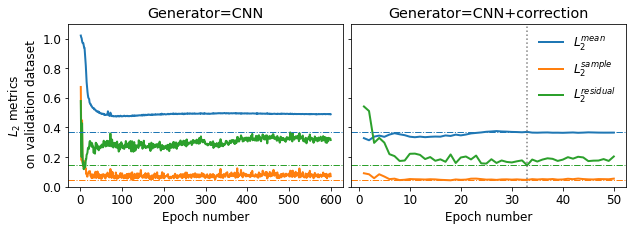

In [167]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace=0.03)

ax = axs[0]
stats_none.L2_mean_test.plot(ax=ax, lw=2, label='$L_2^{mean}$')
stats_none.L2_total_test.plot(ax=ax, lw=2, label='$L_2^{sample}$')
stats_none.L2_residual_test.plot(ax=ax, lw=2, label='$L_2^{residual}$')
ax.set_xlabel('Epoch number')
ax.set_ylabel('$L_2$ metrics \n on validation dataset')
ax.set_ylim([0, 1.1])
ax.set_title('Generator=CNN')

ax = axs[1]
stats_correction.L2_mean_test.plot(ax=ax, lw=2, label='$L_2^{mean}$')
stats_correction.L2_total_test.plot(ax=ax, lw=2, label='$L_2^{sample}$')
stats_correction.L2_residual_test.plot(ax=ax, lw=2, label='$L_2^{residual}$')
ax.set_xlabel('Epoch number')
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_title('Generator=CNN+correction')
ax.set_ylim([0, 1.1])
ax.legend(frameon=False)
epoch = stats_correction.Epoch_opt
ax.axvline(x=epoch, ls=':', color='gray')

for ax in axs:
    ax.axhline(y=stats_correction.L2_mean_test.sel(epoch=epoch), ls='-.', lw=1, color='#1f77b4')
    ax.axhline(y=stats_correction.L2_total_test.sel(epoch=epoch), ls='-.', lw=1, color='#ff7f0e')
    ax.axhline(y=stats_correction.L2_residual_test.sel(epoch=epoch), ls='-.', lw=1, color='#2ca02c')


plt.savefig('paper_figures/training.pdf', bbox_inches='tight', pad_inches=0)

# Metrics across models and resolutions

In [157]:
def L2(type='mean', model='OLSModel', operator='Operator1', resolution=64):
    folder = '/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'
    file = os.path.join(folder, operator+'-'+str(resolution),model,'offline_test.nc')
    if os.path.exists(file):
        ds = xr.open_dataset(file)
        if type != 'var_ratio':
            return float(ds['L2_'+type])
        else:
            return float(ds[type].mean())
    else:
        print('Wrong path', file)

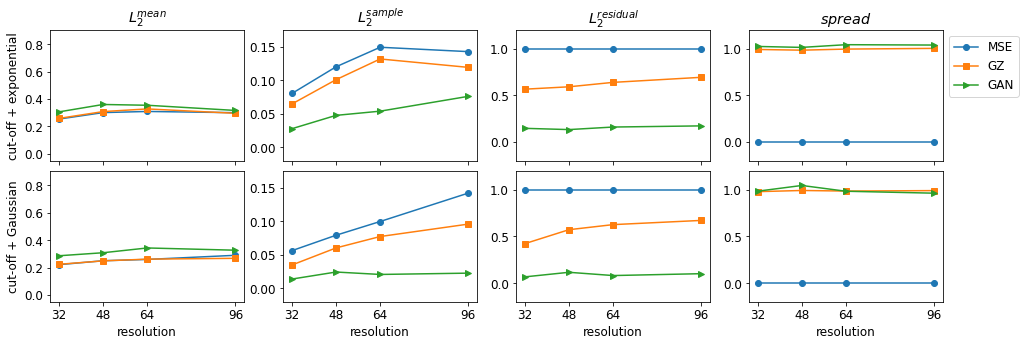

In [159]:
plt.rcParams.update({'font.size': 12})
markers = ['o', 's', '>', '<']
fig, axs = plt.subplots(2,4,figsize=(16,5))
plt.subplots_adjust(hspace=0.08, wspace=0.2)
for i, operator in enumerate(['Operator1', 'Operator2']):
    for j, (model, label) in enumerate(zip(['OLSModel', 'MeanVarModel', 'CGANRegression'], ['MSE', 'GZ', 'GAN'])):
        res = [32, 48, 64, 96]
        L2_mean     = [L2('mean', model, operator, resolution) for resolution in res]
        L2_total    = [L2('total', model, operator, resolution) for resolution in res]
        L2_residual = [L2('residual', model, operator, resolution) for resolution in res]
        var_ratio = [L2('var_ratio', model, operator, resolution) for resolution in res]
        
        ax = axs[i][0]
        ax.plot(res, L2_mean, label=label, marker=markers[j])
        ax.set_ylim([-0.05, 0.905])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        
        ax = axs[i][1]
        ax.plot(res, L2_total, label=label, marker=markers[j])
        ax.set_ylim([-0.02, 0.175])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        #ax.set_yticklabels(['', '', ''])
        
        ax = axs[i][2]
        ax.plot(res, L2_residual, label=label, marker=markers[j])
        ax.set_ylim([-0.2, 1.2])
        #ax.set_ylim([1e-2, 2])
        #ax.set_yticks([1e-2, 1e-1, 1e0])
        #ax.set_yticklabels(['', '', ''])
        
        ax = axs[i][3]
        ax.plot(res, var_ratio, label=label, marker=markers[j])
        ax.set_ylim([-0.2, 1.2])
        
for j in range(4):
    axs[1][j].set_xlabel('resolution')
    axs[1][j].set_xticks([32, 48, 64, 96])
    axs[0][j].set_xticks([32, 48, 64, 96])
    axs[0][j].set_xticklabels([])
axs[0][0].set_title('$L_2^{mean}$')
axs[0][1].set_title('$L_2^{sample}$')
axs[0][2].set_title('$L_2^{residual}$')
axs[0][3].set_title('$spread$')

axs[0][0].set_ylabel('cut-off + exponential')
axs[1][0].set_ylabel('cut-off + Gaussian')

axs[0][3].legend(bbox_to_anchor=(1,1))

plt.savefig('paper_figures/metrics_updated.pdf', bbox_inches='tight', pad_inches=0)

# Snapshot

In [112]:
def imshow(ax, field, title, vmax, cmap='bwr'):
    if vmax is None:
        vmax = np.percentile(field.values.ravel(), 99)
    
    if field.min() < 0:
        vmin = -vmax
    else:
        vmin = 0

    im = ax.imshow(field, vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return im

In [113]:
def reader(path):
    ds = xr.open_dataset(path)
    time = slice(44,None)
    var1 = np.mean((ds.q_forcing_advection_res.isel(time=time, lev=0).astype('float64'))**2)
    var2 = np.mean((ds.q_forcing_advection_res.isel(time=time, lev=1).astype('float64'))**2)
    ds['CSD_res_ND'] = ds.CSD_res * ds.k / np.sqrt(var1 * var2)
    ds['CSD_gen_res_ND'] = ds.CSD_gen_res * ds.k / np.sqrt(var1 * var2)
    
    ds = ds.drop_vars(('PDF0', 'PDF1', 'PDF_gen0', 'PDF_gen1', 'PDF_mean0', 'PDF_mean1', 
                       'PDF_res0', 'PDF_res1', 'PDF_gen_res0', 'PDF_gen_res1', 'q_0', 'q_1'))
    
    time = slice(44,None)
    Nbins = 50
    target = 'q_forcing_advection'
    for lev in [0,1]:
        arr = ds[target].isel(time=time, lev=lev)
        mean, std = arr.mean(), arr.std()
        xmin = float(mean - 4*std); xmax = float(mean + 4*std)
        coords = None
        for suffix in ['', '_gen', '_mean']:
            array = ds[target+suffix].isel(time=time, lev=lev).values.ravel()
            points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
            if coords is None:
                coords=[coord(points, '$dq/dt, s^{-2}$')]
                
            ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='q_'+str(lev), coords=coords,
                attrs={'long_name': 'subgrid forcing PDF'})
    
    for lev in [0,1]:
            arr = ds[target+'_res'].isel(time=time, lev=lev)
            mean, std = arr.mean(), arr.std()
            xmin = float(mean - 4*std); xmax = float(mean + 4*std)
            coords = None
            for suffix in ['_res', '_gen_res']:
                array = ds[target+suffix].isel(time=time, lev=lev).values.ravel()
                points, density = PDF_histogram(array, xmin = xmin, xmax=xmax, Nbins=Nbins)
                if coords is None:
                    coords=[coord(points, '$dq/dt, s^{-2}$')]
                ds['PDF'+suffix+str(lev)] = xr.DataArray(density, dims='dq_'+str(lev), coords=coords,
                    attrs={'long_name': 'subgrid forcing residual PDF'})
    
    return ds

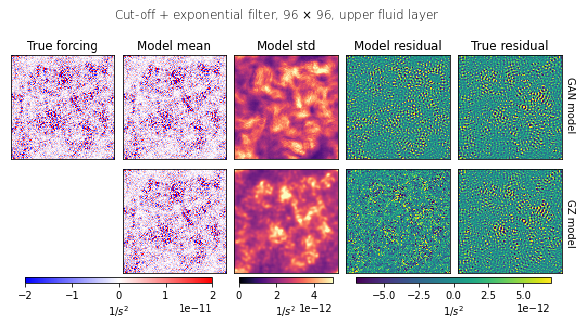

In [118]:
#prms = {'v_total': 8e-13, 'v_std': 2e-14, 'v_residual': 2e-13, 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 15, 'time': -1}
#prms = {'v_total': 3e-11, 'v_std': 2e-12, 'v_residual': 3e-11, 'resolution': 64, 'Operator': 'Operator2', 'lev': 0, 'run': 15, 'time': -1}
#prms = {'v_total': 4e-13, 'v_std': 3e-14, 'v_residual': 1e-13, 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}
#prms = {'v_total': 8e-13, 'v_std': 8e-14, 'v_residual': 2e-13, 'resolution': 64, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}

#prms = {'v_total': 4e-13, 'v_std': 3e-14, 'v_residual': 5e-14, 'file': 'snapshot_op1.pdf', 'suptitle': r'Cut-off + exponential filter, 96 $ \times $ 96, lower fluid layer', 'resolution': 96, 'Operator': 'Operator1', 'lev': 1, 'run': 16, 'time': -1}
#prms = {'v_total': 1.5e-13, 'v_std': 1.8e-14, 'v_residual': 3e-14, 'file': 'snapshot_op2.pdf', 'suptitle': r'Cut-off + Gaussian filter, 96 $ \times $ 96, lower fluid layer', 'resolution': 96, 'Operator': 'Operator2', 'lev': 1, 'run': 16, 'time': -1}
prms = {'v_total': 2e-11, 'v_std': 5e-12, 'v_residual': 7e-12, 'file': 'snapshot_op1_upper.pdf', 'suptitle': r'Cut-off + exponential filter, 96 $ \times $ 96, upper fluid layer', 'resolution': 96, 'Operator': 'Operator1', 'lev': 0, 'run': 16, 'time': -1}

plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(2,5,figsize=(10,4))
plt.subplots_adjust(hspace=0.1, wspace=0.01)
gan = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
gz = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel/offline_test.nc').isel(run=prms['run'],time=prms['time'],lev=prms['lev'])
imshow(axs[0][0], gan.q_forcing_advection, 'True forcing', vmax=prms['v_total'])
art_mean = imshow(axs[0][1], gan.q_forcing_advection_mean, 'Model mean', vmax=prms['v_total'])
art_std  = imshow(axs[0][2], gan.q_forcing_advection_std, 'Model std', vmax=prms['v_std'], cmap='magma')
art_residual = imshow(axs[0][3], gan.q_forcing_advection_gen_res, 'Model residual', vmax=prms['v_residual'], cmap=None)
art_residual = imshow(axs[0][4], gan.q_forcing_advection_res, 'True residual', vmax=prms['v_residual'], cmap=None)

#gan['PDF'+str(prms['lev'])].plot(ax = axs[1][0], ls='--', lw=3, color='k', label='True')
#gan['PDF_gen'+str(prms['lev'])].plot(ax = axs[1][0], ls='-')
axs[1][0].remove()

imshow(axs[1][1], gz.q_forcing_advection_mean, '', vmax=prms['v_total'])
imshow(axs[1][2], gz.q_forcing_advection_std, '', vmax=prms['v_std'], cmap='magma')
imshow(axs[1][3], gz.q_forcing_advection_gen_res, '', vmax=prms['v_residual'], cmap=None)
imshow(axs[1][4], gz.q_forcing_advection_res, '', vmax=prms['v_residual'], cmap=None)

plt.colorbar(art_mean, cax=fig.add_axes([0.15,0.09,0.26,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(art_std, cax=fig.add_axes([0.447,0.09,0.13,0.02]), orientation='horizontal', label='$1/s^2$')
plt.colorbar(art_residual, cax=fig.add_axes([0.61,0.09,0.27,0.02]), orientation='horizontal', label='$1/s^2$')
fig.text(0.9,0.62,'GAN model', rotation=-90)
fig.text(0.9,0.22,'GZ model', rotation=-90)

fig.suptitle(prms['suptitle'], y=1.05, fontweight='light')

plt.savefig(f'paper_figures/{prms["file"]}', bbox_inches='tight', pad_inches=0)

# Distribution plot

In [234]:
prms = {'resolution': 48, 'Operator': 'Operator1'}
gan = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/CGANRegression/offline_test.nc')
gz = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/MeanVarModel/offline_test.nc')
mse = reader('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+prms['Operator']+'-'+str(prms['resolution'])+'/OLSModel/offline_test.nc')

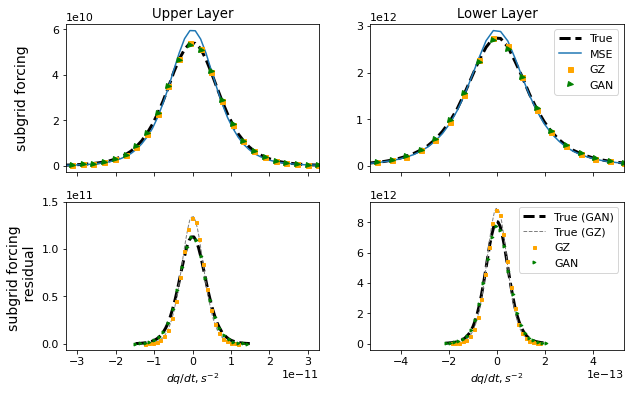

In [240]:
plt.rcParams.update({'font.size': 11})
fig, axs = plt.subplots(2,2,figsize=(10,6))
markers = ['o', 's', '>', '<']
colors = []

gan.PDF0.plot(ax=axs[0][0], color='k', lw=3, ls='--', label='True')
mse.PDF_gen0.plot(ax=axs[0][0], label='MSE', markevery=2)
gz.PDF_gen0.plot(ax=axs[0][0],marker=markers[1], label='GZ', lw=0, markevery=2, markersize=5, color='orange')
gan.PDF_gen0.plot(ax=axs[0][0],marker=markers[2], label='GAN', lw=0, markevery=2, markersize=5, color='green')
axs[0][0].set_xlim([-3.3e-11, 3.3e-11])
axs[0][0].set_xticklabels([])
axs[0][0].set_xlabel('')

gan.PDF_res0.plot(ax=axs[1][0], color='k', lw=3, ls='--')
gz.PDF_res0.plot(ax=axs[1][0], color='gray', lw=1, ls='--')
gz.PDF_gen_res0.plot(ax=axs[1][0], marker=markers[1], label='GZ', lw=0, markevery=2, markersize=3, color='orange')
gan.PDF_gen_res0.plot(ax=axs[1][0], marker=markers[2], label='GAN', lw=0, markevery=2, markersize=3, color='green')
axs[1][0].set_xlim([-3.3e-11, 3.3e-11])
axs[1][0].set_yticks([0, 5e+10, 1e+11, 15e+10])

#############################################
gan.PDF1.plot(ax=axs[0][1], color='k', lw=3, ls='--', label='True')
mse.PDF_gen1.plot(ax=axs[0][1], label='MSE', markevery=2)
gz.PDF_gen1.plot(ax=axs[0][1],marker=markers[1], label='GZ', lw=0, markevery=2, markersize=5, color='orange')
gan.PDF_gen1.plot(ax=axs[0][1],marker=markers[2], label='GAN', lw=0, markevery=2, markersize=5, color='green')
axs[0][1].set_xlim([-5.3e-13, 5.3e-13])
axs[0][1].set_xticklabels([])
axs[0][1].set_xlabel('')


gan.PDF_res1.plot(ax=axs[1][1], color='k', lw=3, ls='--', label='True (GAN)')
gz.PDF_res1.plot(ax=axs[1][1], color='gray', lw=1, ls='--', label='True (GZ)')
gz.PDF_gen_res1.plot(ax=axs[1][1], marker=markers[1], label='GZ', lw=0, markevery=2, markersize=3, color='orange')
gan.PDF_gen_res1.plot(ax=axs[1][1], marker=markers[2], label='GAN', lw=0, markevery=2, markersize=3, color='green')
axs[1][1].set_xlim([-5.3e-13, 5.3e-13])

axs[0][0].set_title('Upper Layer')
axs[0][1].set_title('Lower Layer')
axs[0][1].legend(bbox_to_anchor=(1,1))
axs[1][1].legend(bbox_to_anchor=(1,1))
axs[0][0].set_ylabel('subgrid forcing', labelpad=23, fontsize=14)
axs[1][0].set_ylabel('subgrid forcing \n residual', fontsize=14)
axs[0][1].set_ylabel('')
axs[1][1].set_ylabel('')

plt.savefig(f'paper_figures/pdf_op1_48.pdf', bbox_inches='tight', pad_inches=0)

# Power spectrum

In [297]:
def plot_spectra(operator='Operator2', resolution=96, lev=0, file='paper_figures/spectra_offline.pdf'):
    plt.rcParams.update({'font.size': 11})
    font_title=10
    font_ylabel=12

    gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/CGANRegression/offline_test.nc').isel(lev=lev)
    gz = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/MeanVarModel/offline_test.nc').isel(lev=lev)
    mse = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/OLSModel/offline_test.nc').isel(lev=lev)
    #ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/Operator2-96/*.nc', combine='nested', concat_dim='run').isel(run=slice(275,300))

    fig, axs = plt.subplots(2,2,figsize=(10,5))
    plt.subplots_adjust(wspace=0.25)

    ax = axs[0][0]
    mse.Eflux.plot(ax=ax, label='Truth', color='k', ls='--', lw=3)
    mse.Eflux_gen.plot(ax=ax, label='MSE')
    gz.Eflux_gen.plot(ax=ax, label='GZ')
    gan.Eflux_gen.plot(ax=ax, label='GAN')
    ax.set_title('Energy contribution spectrum', fontsize=font_title)
    ax.set_ylabel('$m^3/s^3$', fontsize=font_ylabel)

    ax = axs[0][1]
    mse.PSD.plot(ax=ax, label='Truth', color='k', ls='--', lw=3)
    mse.PSD_gen.plot(ax=ax, label='MSE')
    gz.PSD_gen.plot(ax=ax, label='GZ')
    gan.PSD_gen.plot(ax=ax, label='GAN')
    ax.set_title('Power spectrum of subgrid forcing', fontsize=font_title)
    ax.set_ylabel('$m/s^4$', fontsize=font_ylabel)

    ax = axs[1][0]
    gan.PSD_res.plot(ax=ax, label='True (GAN)', ls='--', color='k', lw=3)
    gz.PSD_res.plot(ax=ax, label='True (GZ)', ls='--', color='gray', lw=2)
    mse.PSD_gen_res.plot(ax=ax, label='MSE')
    gz.PSD_gen_res.plot(ax=ax, label='GZ')
    gan.PSD_gen_res.plot(ax=ax, label='GAN')
    ax.set_title('Power spectrum of residuals', fontsize=font_title)
    ax.set_ylabel('$m/s^4$', fontsize=font_ylabel)
    ax.legend(fontsize=11, frameon=False)

    ax = axs[1][1]
    gan.CSD_res.plot(ax=ax, ls='--', color='k', lw=3)
    gz.CSD_res.plot(ax=ax, ls='--', color='gray', lw=2)
    ax.plot([], [])
    gz.CSD_gen_res.plot(ax=ax, label='GZ')
    gan.CSD_gen_res.plot(ax=ax, label='GAN')
    ax.set_title('Cross layer covariance of residuals', fontsize=font_title)
    ax.set_ylabel('$m/s^4$', fontsize=font_ylabel)
    
    dx = gan.x[2] - gan.x[1]
    for i in [0,1]:
        for j in [0,1]:
            axs[i][j].axvline(x=np.pi/dx, ls=':', color='gray')
            if operator == 'Operator1':
                axs[i][j].axvline(x=0.65*np.pi/dx, ls='-.', color='gray', lw=1)
                
    if resolution==96:
        axs[0][0].text(0.0002, 2.5e-6, 'Nyquist frequency')
        axs[0][0].text(0.00028, 2e-6, '$\pi/dx$')
    else:
        #axs[0][0].text(0.000135, 1.7e-6, 'Nyquist frequency')
        axs[0][0].text(np.pi/dx-0.00001, 1e-6, '$\pi/dx$')  
        axs[0][0].text(0.65*np.pi/dx-0.00003, 1e-6, '$0.65\pi/dx$')
        
    for j in [0,1]:
        axs[0][j].set_xticks([0, 0.0001, 0.0002, 0.0003, 0.0004])
        axs[0][j].set_xticklabels([])
        axs[0][j].set_xlabel('')
        axs[1][j].set_xticks([0, 0.0001, 0.0002, 0.0003, 0.0004])
        axs[1][j].set_xlabel('wavenumber [$m^{-1}$]')
        if resolution==64:
            axs[1][j].set_xlim([0, 0.0003])
            axs[0][j].set_xlim([0, 0.0003])
    
    fig.align_ylabels(axs[:,0])
    fig.align_ylabels(axs[:,1])
    
    gan = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/'+operator+'-'+str(resolution)+'/CGANRegression/offline_test.nc')
    print('Correlation = ', float(xr.corr(gan.q_forcing_advection_res.isel(lev=0), gan.q_forcing_advection_res.isel(lev=1))))
    plt.savefig(file, bbox_inches='tight', pad_inches=0)

Correlation =  -0.04634802757959109


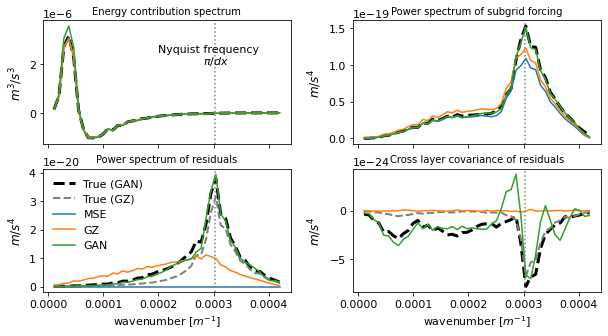

In [298]:
plot_spectra()

Correlation =  -0.023166999800145423


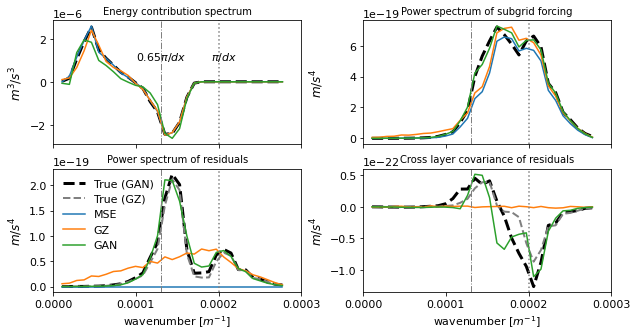

In [299]:
plot_spectra('Operator1', 64, 0, 'paper_figures/spectra_offline_sharp.pdf')

# Similarity scores

In [160]:
with open('difference.json', 'r') as file:
    difference = json.load(file)

In [171]:
def resolution_slice(d, operator, model, metric1=distrib_score, metric2=spectral_score):
    resolutions=[48, 64, 96]
    keys = [f'{operator}-{str(res)}/{model}' for res in resolutions]
    dist = [metric1(d.get(key, {})) for key in keys]
    spec = [metric2(d.get(key, {})) for key in keys]
    return xr.DataArray(dist, coords=[resolutions]), xr.DataArray(spec, coords=[resolutions])

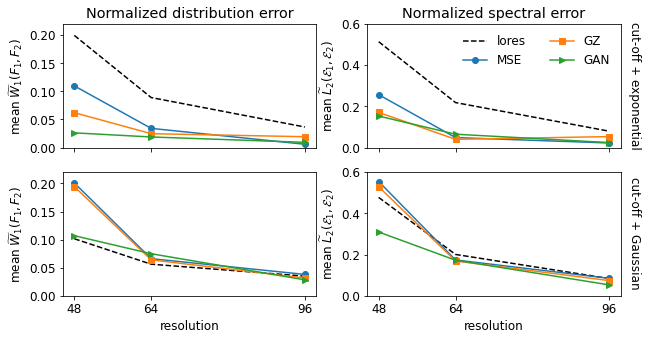

In [187]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.2)

for row, operator in enumerate(['Operator1', 'Operator2']):
    for model, name, marker, color, lw, ls in zip(['Reference', 'OLSModel/eddy-constant-0', 'MeanVarModel/eddy-constant-0', 'CGANRegression/eddy-constant-0'],# 'CGANRegressionxy-full/eddy-constant-0'], 
                        ['lores', 'MSE', 'GZ', 'GAN', 'GANxy'], ['', 'o', 's', '>', '<'], 
                        ['k',None,None,None,None], [1.5]+[1.5]*4, ['--', '-', '-', '-','-']):
        dist, spec = resolution_slice(difference, operator, model)
        dist.plot(ax=axs[row][0], label=name, marker=marker, color=color, lw=lw, ls=ls)
        spec.plot(ax=axs[row][1], label=name, marker=marker, color=color, lw=lw, ls=ls)
axs[0][0].set_title('Normalized distribution error')
axs[0][1].set_title('Normalized spectral error')
axs[0][0].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')
axs[1][0].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')
axs[0][1].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')
axs[1][1].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')

fig.text(0.91,0.54,'cut-off + exponential', rotation=-90)
fig.text(0.91,0.15,'cut-off + Gaussian', rotation=-90)

axs[0][1].legend(frameon=False, ncol=2)
for i in [0,1]:
    for j in [0,1]:
        if i==0:
            axs[i][j].set_xticklabels([])
            axs[i][j].set_xlabel('')
        else:
            axs[i][j].set_xlabel('resolution')
        axs[i][j].set_xticks([48, 64, 96])
        
axs[0][0].set_ylim([0, 0.22])
axs[1][0].set_ylim([0, 0.22])
axs[0][1].set_ylim([0,0.6])
axs[1][1].set_ylim([0,0.6])
plt.savefig('paper_figures/online_errors.pdf', bbox_inches='tight', pad_inches=0.1)

In [173]:
def sampling_slice(d, operator, model, res):
    if model == 'Reference':
        key = f'{operator}-{str(res)}/Reference'
        dist = [distrib_score(d.get(key,{}))]*5
        spec = [spectral_score(d.get(key,{}))]*5
    else:
        keys = [f'{operator}-{str(res)}/{model}/{sampling}' \
                for sampling in ['eddy-constant-0', 'eddy-AR1-12', 'eddy-AR1-24', 'eddy-AR1-36', 'eddy-AR1-48']]    
        dist = [distrib_score(d.get(key, {})) for key in keys]
        spec = [spectral_score(d.get(key, {})) for key in keys]
    
    if model == 'OLSModel':
        for j in range(1,5):
            dist[j]=dist[0]
            spec[j] = spec[0]
            
    T = [0, 12, 24, 36, 48]
    return xr.DataArray(dist, coords=[T]), xr.DataArray(spec, coords=[T])

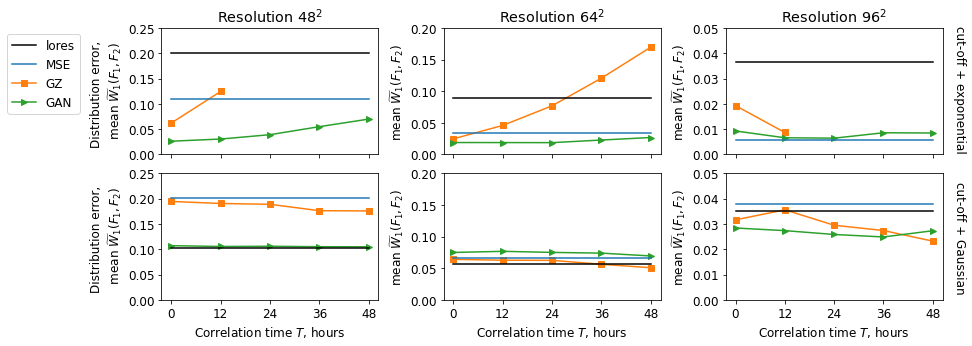

In [185]:
import matplotlib.pylab as pl
colors = [
[0., 0., 0.],
'#1f77b4',
'#ff7f0e', 
'#2ca02c',
[0., 0., 0.]
]

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2,3, figsize=(14,5))
plt.subplots_adjust(wspace=0.3, hspace=0.15)

for row, operator in enumerate(['Operator1', 'Operator2']):
    for col, res in enumerate([48, 64, 96]):
        for model, name, marker, zorder, color in zip(['Reference', 'OLSModel', 'MeanVarModel', 'CGANRegression'],# 'CGANRegressionxy-full'],
                            ['lores', 'MSE', 'GZ', 'GAN', 'GANxy'], ['', '', 's', '>', '<'], 
                            [3, 4, 1, 2, 5], colors):
            dist, spec = sampling_slice(difference, operator, model, res)
            dist.plot(ax=axs[row][col], label=name, ls='-', color=color, marker=marker, zorder=zorder)
            #spec.plot(ax=axs[row][col], ls='--', color=color, marker=marker, zorder=zorder+4)

titles = ['Resolution $48^2$', 'Resolution $64^2$', 'Resolution $96^2$']
for row in [0,1]:
    for col in [0,1,2]:
        axs[row][col].set_xticks([0, 12, 24, 36, 48])
        axs[1][col].set_xlabel('Correlation time $T$, hours')
        axs[0][col].set_xlabel('')
        axs[0][col].set_xticklabels([])
        axs[0][col].set_title(titles[col])
axs[0][0].set_ylim([0, 0.25])
axs[1][0].set_ylim([0, 0.25])
axs[0][1].set_ylim([0, 0.2])
axs[1][1].set_ylim([0, 0.2])
axs[0][2].set_ylim([0, 0.05])
axs[1][2].set_ylim([0, 0.05])

axs[0][0].set_ylabel('Distribution error, \n mean $\widetilde{W}_1(F_1,F_2)$')
axs[1][0].set_ylabel('Distribution error, \n mean $\widetilde{W}_1(F_1,F_2)$')
axs[0][1].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')
axs[1][1].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')
axs[0][2].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')
axs[1][2].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')


axs[0][0].legend(bbox_to_anchor=(-0.35,1))
fig.text(0.91,0.54,'cut-off + exponential', rotation=-90)
fig.text(0.91,0.15,'cut-off + Gaussian', rotation=-90)

plt.savefig('paper_figures/online_correlation_distrib.pdf', bbox_inches='tight', pad_inches=0.1)

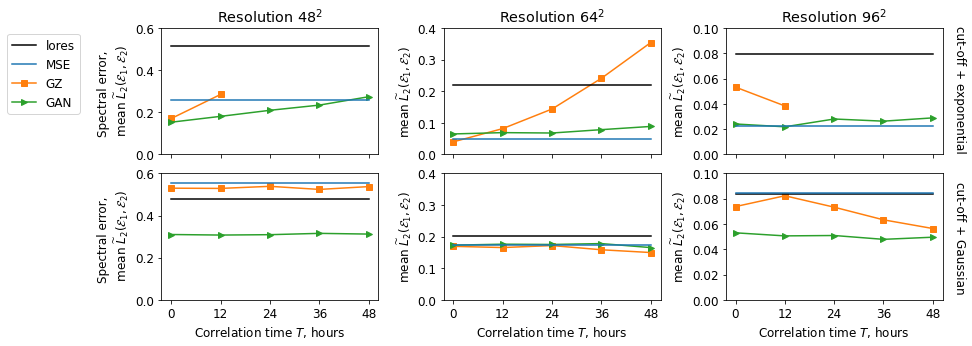

In [184]:
import matplotlib.pylab as pl
colors = [
[0., 0., 0.],
'#1f77b4',
'#ff7f0e', 
'#2ca02c',
[0., 0., 0.]
]

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2,3, figsize=(14,5))
plt.subplots_adjust(wspace=0.3, hspace=0.15)

for row, operator in enumerate(['Operator1', 'Operator2']):
    for col, res in enumerate([48, 64, 96]):
        for model, name, marker, zorder, color in zip(['Reference', 'OLSModel', 'MeanVarModel', 'CGANRegression'],#, 'CGANRegressionxy-full'],
                            ['lores', 'MSE', 'GZ', 'GAN', 'GAN-residual'], ['', '', 's', '>', '<'], 
                            [3, 4, 1, 2, 5], colors):
            dist, spec = sampling_slice(difference, operator, model, res)
            spec.plot(ax=axs[row][col], label=name, ls='-', color=color, marker=marker, zorder=zorder)
            #spec.plot(ax=axs[row][col], ls='--', color=color, marker=marker, zorder=zorder+4)

titles = ['Resolution $48^2$', 'Resolution $64^2$', 'Resolution $96^2$']
for row in [0,1]:
    for col in [0,1,2]:
        axs[row][col].set_xticks([0, 12, 24, 36, 48])
        axs[1][col].set_xlabel('Correlation time $T$, hours')
        axs[0][col].set_xlabel('')
        axs[0][col].set_xticklabels([])
        axs[0][col].set_title(titles[col])
axs[0][0].set_ylim([0, 0.6])
axs[1][0].set_ylim([0, 0.6])
axs[0][1].set_ylim([0, 0.4])
axs[1][1].set_ylim([0, 0.4])
axs[0][2].set_ylim([0, 0.1])
axs[1][2].set_ylim([0, 0.1])

axs[0][0].set_ylabel('Spectral error, \n mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')
axs[1][0].set_ylabel('Spectral error, \n mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')
axs[0][1].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')
axs[1][1].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')
axs[0][2].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')
axs[1][2].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')

axs[0][0].legend(bbox_to_anchor=(-0.35,1))
fig.text(0.91,0.54,'cut-off + exponential', rotation=-90)
fig.text(0.91,0.15,'cut-off + Gaussian', rotation=-90)

plt.savefig('paper_figures/online_correlation_spec.pdf', bbox_inches='tight', pad_inches=0.1)

# Demonstration of statistical characteristics
Among distributions: The most convincing improvement is seen for Enstrophy in 1st layer. Because our models attenuate small-scale features.

(0.0, 0.4)

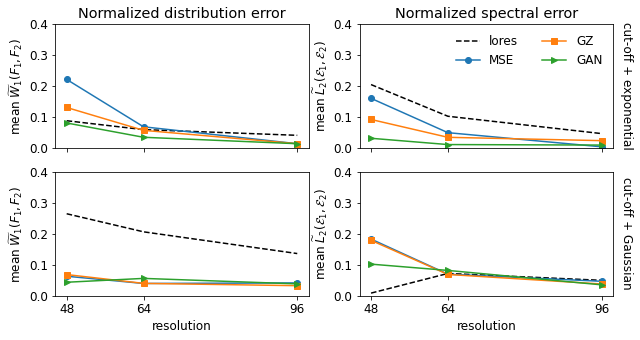

In [71]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.2)

for row, operator in enumerate(['Operator1', 'Operator2']):
    for model, name, marker, color, lw, ls in zip(['Reference', 'OLSModel/eddy-constant-0', 'MeanVarModel/eddy-constant-0', 'CGANRegression/eddy-constant-0'],#, 'CGANRegression-residual/eddy-constant-0'], 
                        ['lores', 'MSE', 'GZ', 'GAN', 'GAN-residual'], ['', 'o', 's', '>', '<'], 
                        ['k',None,None,None,None], [1.5]+[1.5]*4, ['--', '-', '-', '-','-']):
        dist, spec = resolution_slice(difference, operator, model, metric1=lambda x: x['distrib_diff_Ens1'], metric2=lambda x: x['distrib_diff_Ens2'])
        dist.plot(ax=axs[row][0], label=name, marker=marker, color=color, lw=lw, ls=ls)
        spec.plot(ax=axs[row][1], label=name, marker=marker, color=color, lw=lw, ls=ls)
axs[0][0].set_title('Normalized distribution error')
axs[0][1].set_title('Normalized spectral error')
axs[0][0].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')
axs[1][0].set_ylabel('mean $\widetilde{W}_1(F_1,F_2)$')
axs[0][1].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')
axs[1][1].set_ylabel('mean $\widetilde{L}_2(\mathcal{E}_1,\mathcal{E}_2)$')

fig.text(0.91,0.54,'cut-off + exponential', rotation=-90)
fig.text(0.91,0.15,'cut-off + Gaussian', rotation=-90)

axs[0][1].legend(frameon=False, ncol=2)
for i in [0,1]:
    for j in [0,1]:
        if i==0:
            axs[i][j].set_xticklabels([])
            axs[i][j].set_xlabel('')
        else:
            axs[i][j].set_xlabel('resolution')
        axs[i][j].set_xticks([48, 64, 96])
        
axs[0][0].set_ylim([0, 0.4])
axs[1][0].set_ylim([0, 0.4])
axs[0][1].set_ylim([0,0.4])
axs[1][1].set_ylim([0,0.4])

In [236]:
def plot_all_statistics(operator='Operator1', resolution=48, read_cache=True, xlim=[1e-5, 2e-4], ylim1=[1e-1,2e+2], ylim2=[1e-2,1e+1]):
    import matplotlib.pylab as pl
    colors = [
    [0., 0., 0.],
    '#1f77b4',
    '#ff7f0e', 
    '#2ca02c'  
    ]
    
    if resolution==64:
        ylim2=[5e-3,1e+1]
    elif resolution==96:
        xlim=[1e-5, 3e-4]
        ylim1=[1e-2, 2e+2]
        ylim2=[1e-4,1e+1]
    
    dns_line = {'color': 'k', 'ls': '-', 'lw': 1, 'label': 'DNS'}
    target_line = {'color': 'gray', 'ls': '-', 'lw': 2, 'label': 'fDNS'}
    lores_line = {'color': 'gray', 'ls': '--', 'lw': 2, 'label': 'lores'}
    mse_line = {'color': '#1f77b4', 'ls': '-', 'lw': 0.5, 'marker': 'o', 'markersize': 3, 'fillstyle':'none', 'markeredgewidth':1.5, 'label': 'MSE'}
    gz_line = {'color': '#ff7f0e', 'ls': '-', 'lw': 0.5, 'marker': 's', 'markersize': 3, 'fillstyle': 'none', 'markeredgewidth':1.5, 'label': 'GZ'}
    gan_line = {'color': '#2ca02c', 'ls': '-', 'lw': 0.5, 'marker': '>', 'markersize': 3, 'fillstyle':'none', 'markeredgewidth':1.5, 'label': 'GAN'}
    
    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(2,3, figsize=(14,6))
    plt.subplots_adjust(wspace=0.3, hspace=0.65)
    
    hires = dataset_smart_read('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/[0-9].nc', read_cache=read_cache)
    target = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/{operator}-{str(resolution)}.nc', read_cache=read_cache)
    lores = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_{str(resolution)}/[0-9].nc', read_cache=read_cache)
    mse = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/OLSModel/eddy-constant-0/*.nc', read_cache=read_cache)
    gz = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/MeanVarModel/eddy-constant-0/*.nc', read_cache=read_cache)
    gan = dataset_smart_read(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/{operator}-{str(resolution)}/CGANRegression/eddy-constant-0/*.nc', read_cache=read_cache)
    offline = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/{operator}-{str(resolution)}/[0-9].nc', combine='nested', concat_dim='run')
    offline['paramspec_KEfluxr'] = ave_lev(spectrum(type='cospectrum', averaging=True, truncate=True)(-offline.psi, offline.q_forcing_advection), 0.25)
    offline['paramspec_APEfluxr'] = 0*offline['paramspec_KEfluxr']
    
    ax = axs[0][0]
    for model, line in zip([hires, target, lores, mse, gz, gan], 
        [dns_line, target_line, lores_line, mse_line, gz_line, gan_line]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.KEspecr.isel(lev=0).plot(ax=ax, **line2)
    for model, line in zip([hires, target, lores, mse, gz, gan], 
        [dns_line, target_line, lores_line, mse_line, gz_line, gan_line]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.KEspecr.isel(lev=1).plot(ax=ax, **line2)
        
    #ax.set_ylim(ylim1)
    ax.set_ylim([min(ylim2), max(ylim1)])
    ax.set_xlim(xlim)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('KE spectrum')
    ax.set_ylabel('Energy spectrum [$m^3/s^2$]', fontsize=11)
    ax.text(1.2e-4, 1.5e-1, 'lower')
    ax.text(1.2e-4, 1.5e+1, 'upper')
    
    ax = axs[1][0]
    for model, line in zip([hires, target, lores, mse, gz, gan], 
        [dns_line, target_line, lores_line, mse_line, gz_line, gan_line]):
        model.Efluxr.plot(ax=ax, **line)
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim([-1.2e-6, 1.2e-6])
    ax.set_title('Energy transfer \n (resolved+subgrid)')
    ax.set_ylabel('Energy change [$m^3/s^3$]', fontsize=11)
    
    ax=axs[1][1]
    for model, line in zip([offline, mse, gz, gan],
        [target_line, mse_line, gz_line, gan_line]):
        (model.paramspec_APEfluxr + model.paramspec_KEfluxr).plot(ax=ax, **line)
    ax.set_xlim(xlim)
    ax.set_xscale('log')
    ax.set_ylabel('Energy change [$m^3/s^3$]', fontsize=11)
    ax.set_title('Energy transfer \n (subgrid)')
    #ax.set_ylim([-1.5e-6, 1.5e-6])
    
    ax = axs[0][1]
    for model, line in zip([hires, target, lores, mse, gz, gan], 
        [dns_line, target_line, lores_line, mse_line, gz_line, gan_line]):
        model.APEgenspecr.plot(ax=ax, **line)
    ax.set_xscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim([-2e-7, 2.5e-6])
    ax.set_title('Energy source')
    ax.set_ylabel('Energy change [$m^3/s^3$]', fontsize=11)
    
    ax = axs[0][2]
    for model, line in zip([hires, target, lores, mse, gz, gan], 
        [dns_line, target_line, lores_line, mse_line, gz_line, gan_line]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.KE_time.plot(ax=ax, markevery=6, **line2)
    ax.set_title('KE per unit mass')
    ax.set_ylabel('Kinetic energy [$10^{-4} m^2/s^2$]', fontsize=11)
    ax.set_ylim([0, 8e-4])
    ax.set_yticks([0, 2e-4, 4e-4, 6e-4, 8e-4])
    ax.set_yticklabels([0,2,4,6,8])
    
    
    ax = axs[1][2]
    for model, line in zip([hires, target, lores, mse, gz, gan], 
        [dns_line, target_line, lores_line, mse_line, gz_line, gan_line]):
        line2 = line.copy()
        if 'marker' in line:
            line2['lw'] = 0
        model.PDF_Ens1.plot(ax=ax, markevery=2, **line2)
    ax.set_yscale('log')
    ax.set_title('Upper enstrophy PDF')
    ax.set_ylabel('Probability density', fontsize=11)
    ax.set_xlabel('relative enstrophy [$10^{-11}s^{-2}$]')
    ax.set_xticks([0, 2e-11, 4e-11, 6e-11, 8e-11, 10e-11])
    ax.set_xticklabels([0, 2, 4, 6, 8, 10])
    ax.set_ylim([5e+7, 1e+12])
    
    fig.align_ylabels()
    fig.align_xlabels()
    axs[1][2].legend(frameon=False, ncol=2)

In [237]:
read_cache=True

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72312d34382e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-48/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf


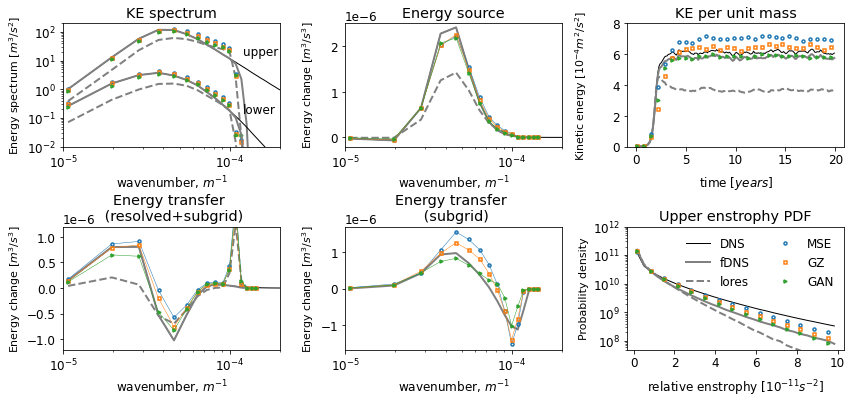

In [238]:
plot_all_statistics('Operator1', 48, read_cache)
plt.savefig('paper_figures/online_overview/op1_48.pdf', bbox_inches='tight', pad_inches=0.1)

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72312d36342e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-64/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf


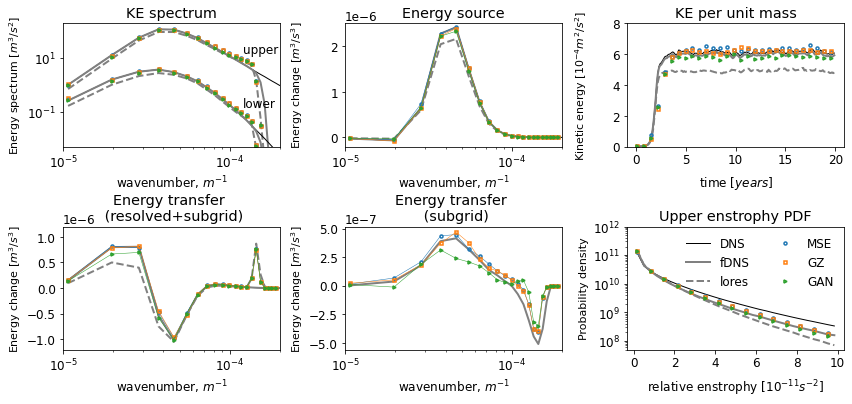

In [239]:
plot_all_statistics('Operator1', 64, read_cache)
plt.savefig('paper_figures/online_overview/op1_64.pdf', bbox_inches='tight', pad_inches=0.1)

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72312d39362e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator1-96/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf


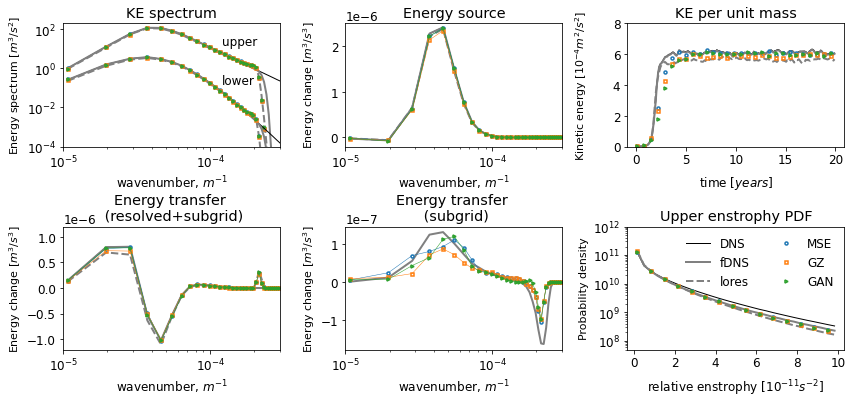

In [240]:
plot_all_statistics('Operator1', 96, read_cache)
plt.savefig('paper_figures/online_overview/op1_96.pdf', bbox_inches='tight', pad_inches=0.1)

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72322d34382e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_48/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-48/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf


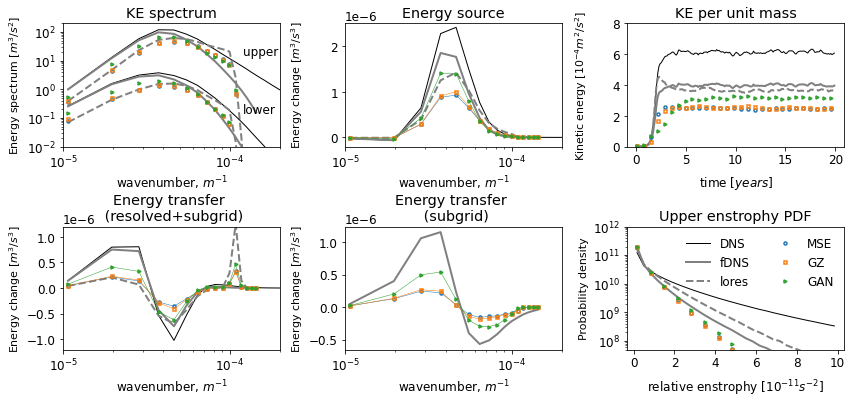

In [241]:
plot_all_statistics('Operator2', 48, read_cache)
plt.savefig('paper_figures/online_overview/op2_48.pdf', bbox_inches='tight', pad_inches=0.1)

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72322d36342e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_64/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-64/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf


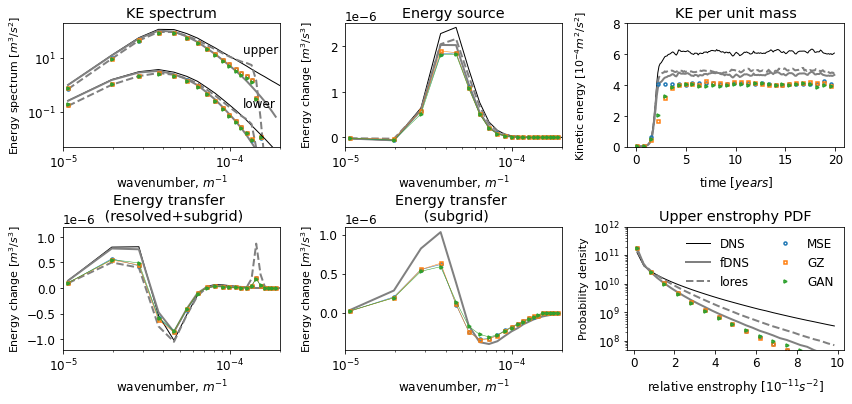

In [242]:
plot_all_statistics('Operator2', 64, read_cache)
plt.savefig('paper_figures/online_overview/op2_64.pdf', bbox_inches='tight', pad_inches=0.1)

Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/4f70657261746f72322d39362e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_96/5b302d395d2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/OLSModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/MeanVarModel/eddy-constant-0/2a2e6e63.cache_netcdf
Read cache /scratch/pp2681/pyqg_generative/Reference-Default-scaled/models/Operator2-96/CGANRegression/eddy-constant-0/2a2e6e63.cache_netcdf


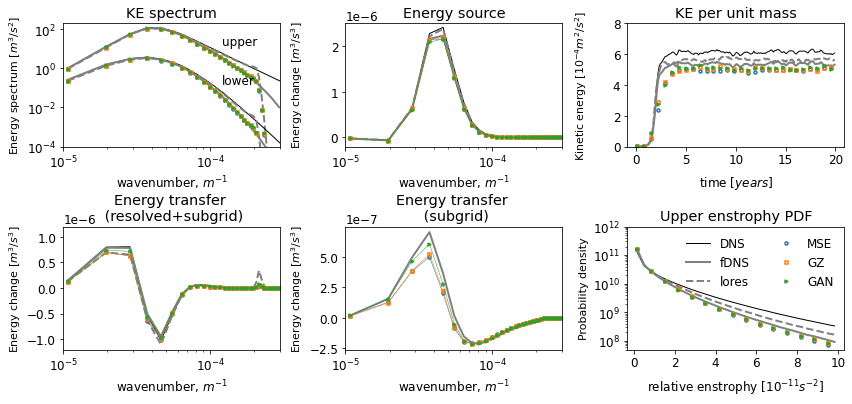

In [243]:
plot_all_statistics('Operator2', 96, read_cache)
plt.savefig('paper_figures/online_overview/op2_96.pdf', bbox_inches='tight', pad_inches=0.1)